# Data Load
[사용 데이터 : Kaggle eCommerce Event Hisotry in Cosmetic Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop).

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
data0 = pd.read_csv('2019-Oct-Copy1.csv')
data1 = pd.read_csv('2019-Nov-Copy1.csv')
data2 = pd.read_csv('2019-Dec-Copy1.csv')
data3 = pd.read_csv('2020-Jan-Copy1.csv')
data4 = pd.read_csv('2020-Feb-Copy1.csv')

In [5]:
temp = pd.concat([data1,data2,data3,data4])

del [[data1, data2, data3, data4]]

# (1) plot_df function
시간에 따른 view, cart, purchase 패턴 시각화 함수
- x축 : timestamp 0~
- y축 : product_id
- blue dot : cart
- red dot : remove_from_cart
- green dot : view
- yellow : purchase

In [4]:
from dateutil.parser import parse
from matplotlib import pyplot as plt

def plot_df(df):
    
    df['timestamp'] = 0
    for i in range(df.shape[0]):
        df.iloc[i, 9] = parse(df.iloc[i,0]).timestamp()
    df['timestamp'] -= df['timestamp'].values.min()

    itemid = df['product_id'].unique()
    itemid_dict = {}
    for i, item in enumerate(itemid):
        itemid_dict[item] = i
    df['itemid'] = df['product_id']
    df['itemid'] = df['itemid'].map(itemid_dict)

    colors = {'cart' : 'blue', 'remove_from_cart' : 'red', 'view' : 'green', 'purchase' : 'yellow'}
    plt.figure(figsize=(50, 50))
    plt.scatter(df['timestamp'],df['itemid'], c = df['event_type'].map(colors),s=300)


In [14]:
user_data = temp[temp['user_id'] == 583884978]
user_data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1047365,2019-12-09 09:04:16 UTC,view,5897532,1487580009286598681,NaN,NaN,2.16,583884978,4c7bda97-c07c-4796-adee-d371722fa3ee
1047411,2019-12-09 09:04:36 UTC,view,5897538,1487580009286598681,NaN,NaN,2.86,583884978,4c7bda97-c07c-4796-adee-d371722fa3ee
1047455,2019-12-09 09:04:54 UTC,view,5897534,1487580009286598681,NaN,NaN,2.16,583884978,4c7bda97-c07c-4796-adee-d371722fa3ee
1047481,2019-12-09 09:05:05 UTC,view,5897536,1487580009286598681,NaN,NaN,2.86,583884978,4c7bda97-c07c-4796-adee-d371722fa3ee
1047503,2019-12-09 09:05:16 UTC,view,5897539,1487580009286598681,NaN,NaN,2.54,583884978,4c7bda97-c07c-4796-adee-d371722fa3ee
...,...,...,...,...,...,...,...,...,...
4142916,2020-02-29 20:45:26 UTC,view,5897546,1487580009286598681,NaN,NaN,2.16,583884978,5de0e2fd-7093-45b2-b7e9-4334f9696757
4142922,2020-02-29 20:45:31 UTC,view,5897543,1487580009286598681,NaN,NaN,2.38,583884978,5de0e2fd-7093-45b2-b7e9-4334f9696757
4142930,2020-02-29 20:45:34 UTC,view,5897540,1487580009286598681,NaN,NaN,2.38,583884978,5de0e2fd-7093-45b2-b7e9-4334f9696757
4142942,2020-02-29 20:45:38 UTC,view,5897542,1487580009286598681,NaN,NaN,2.38,583884978,5de0e2fd-7093-45b2-b7e9-4334f9696757


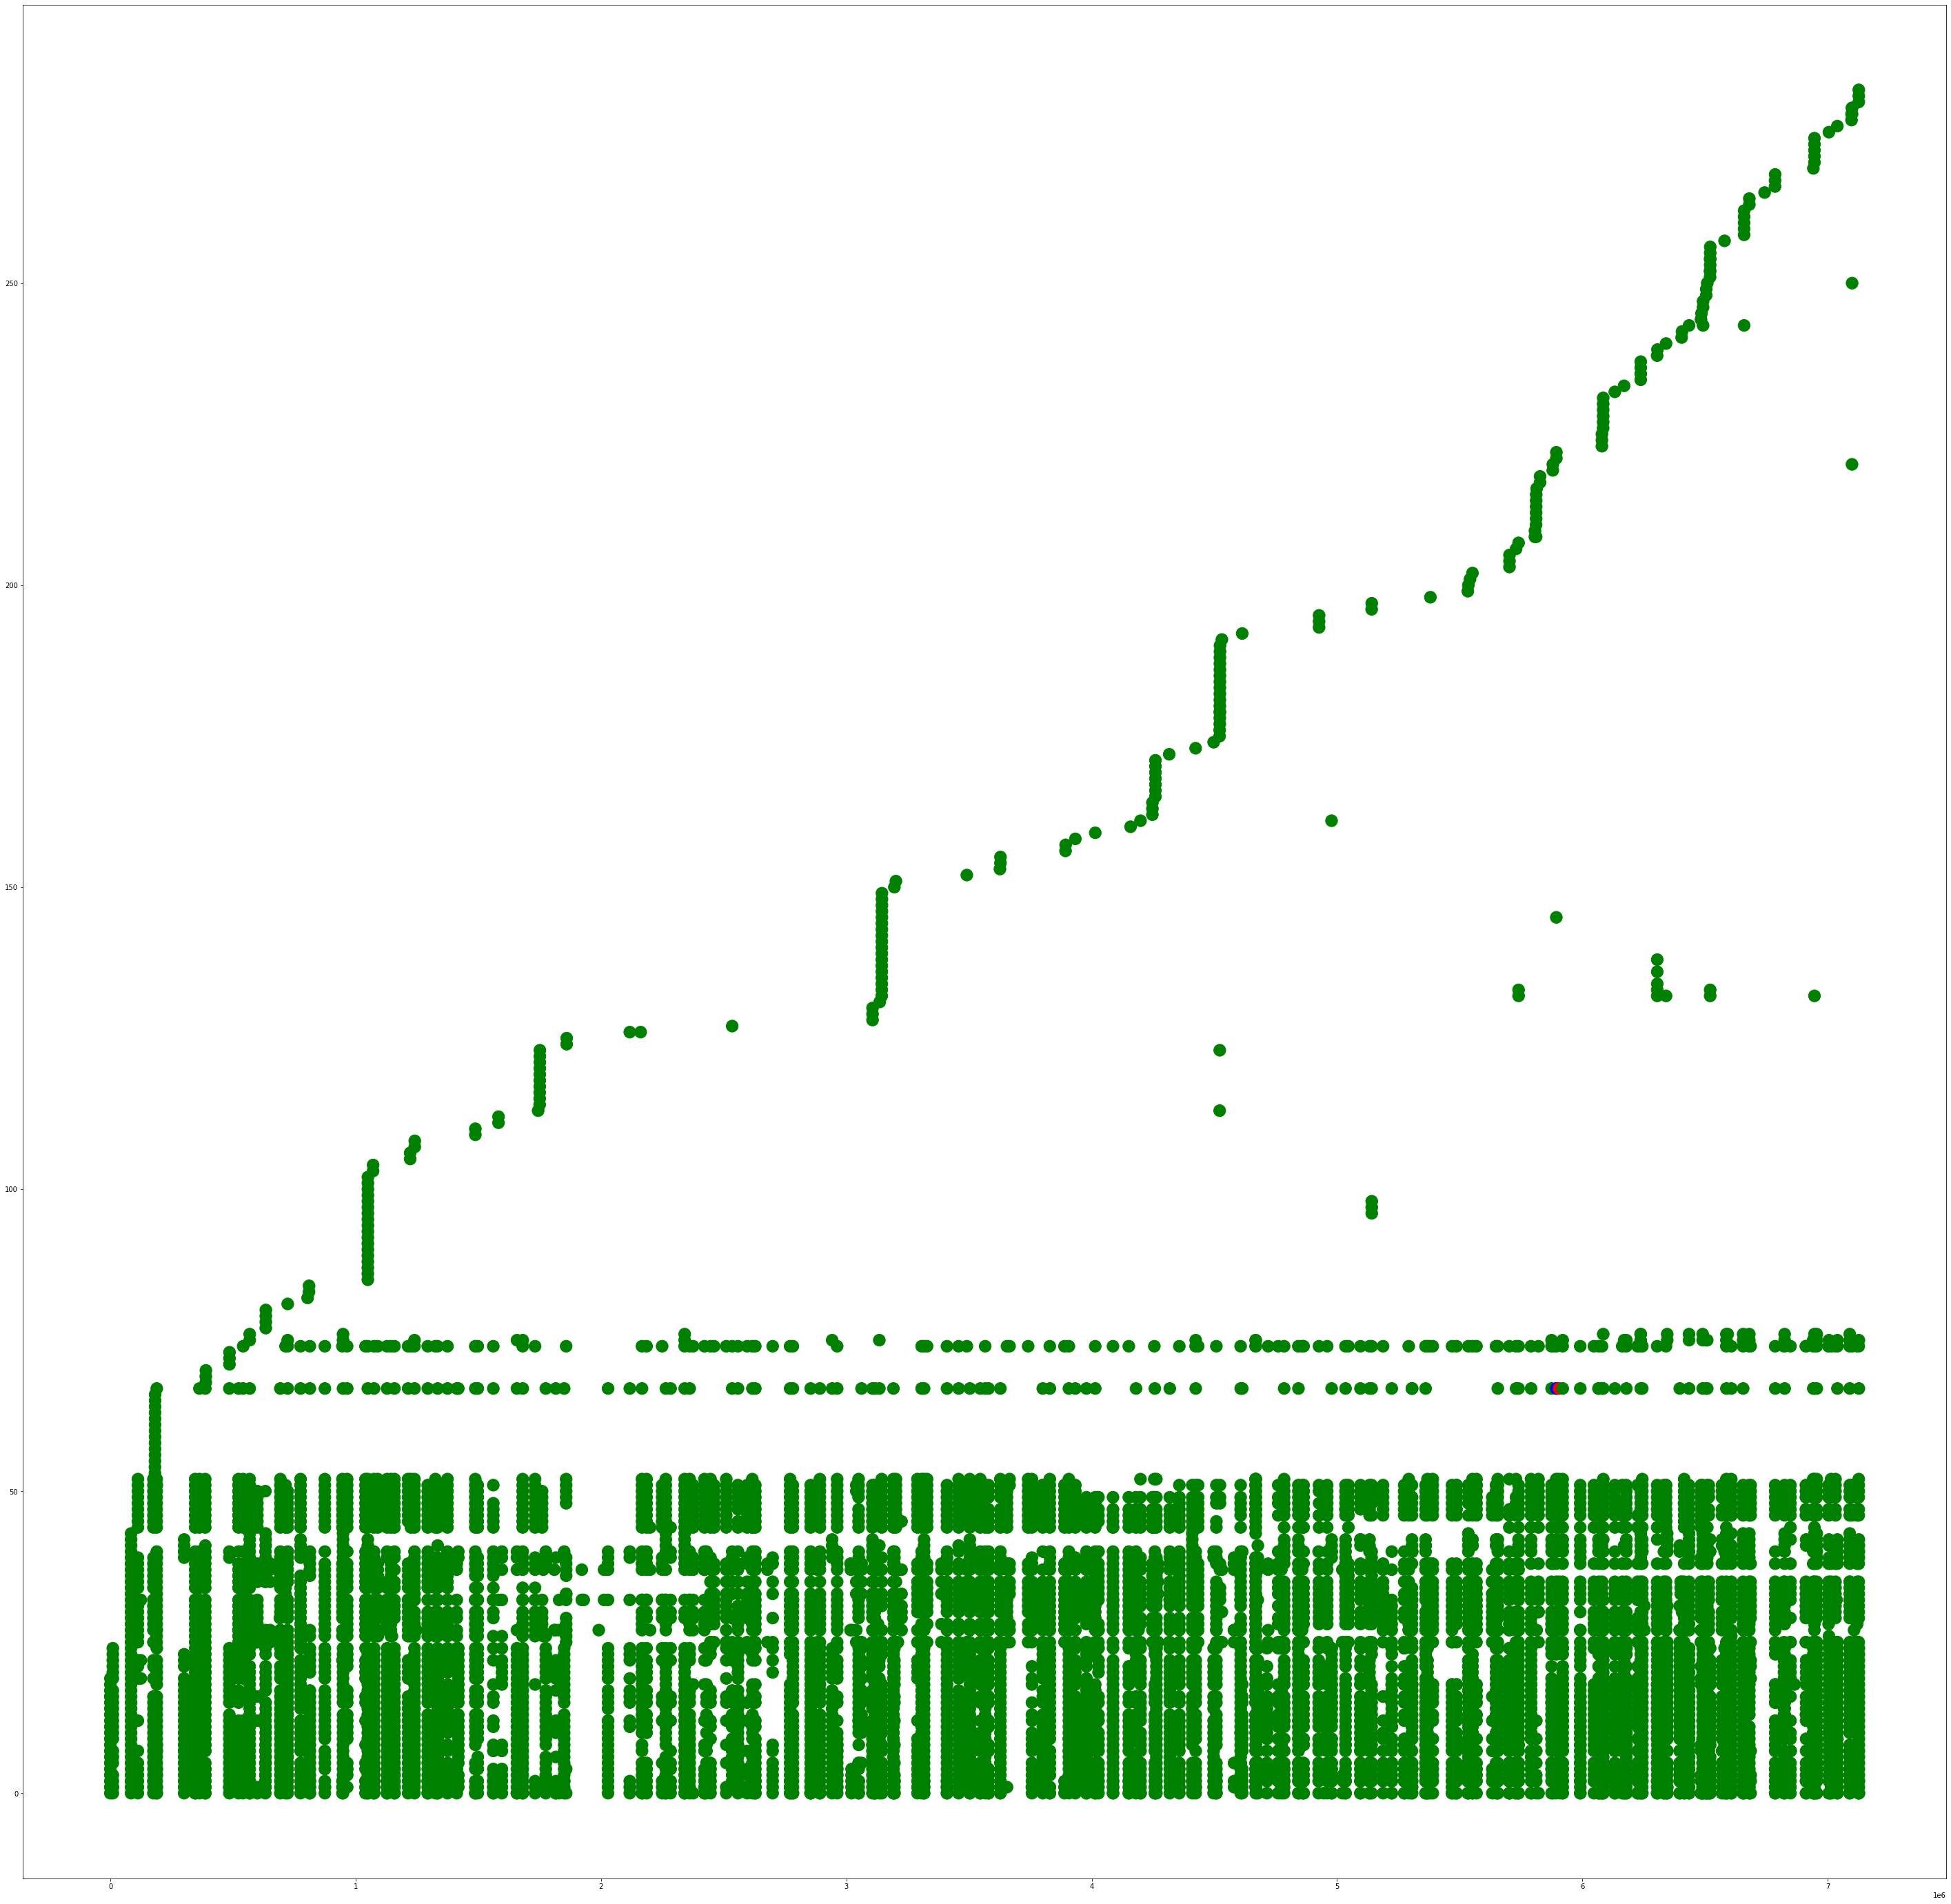

In [15]:
plot_df(user_data)

In [16]:
user_data1 = temp[temp['user_id']==506725430]

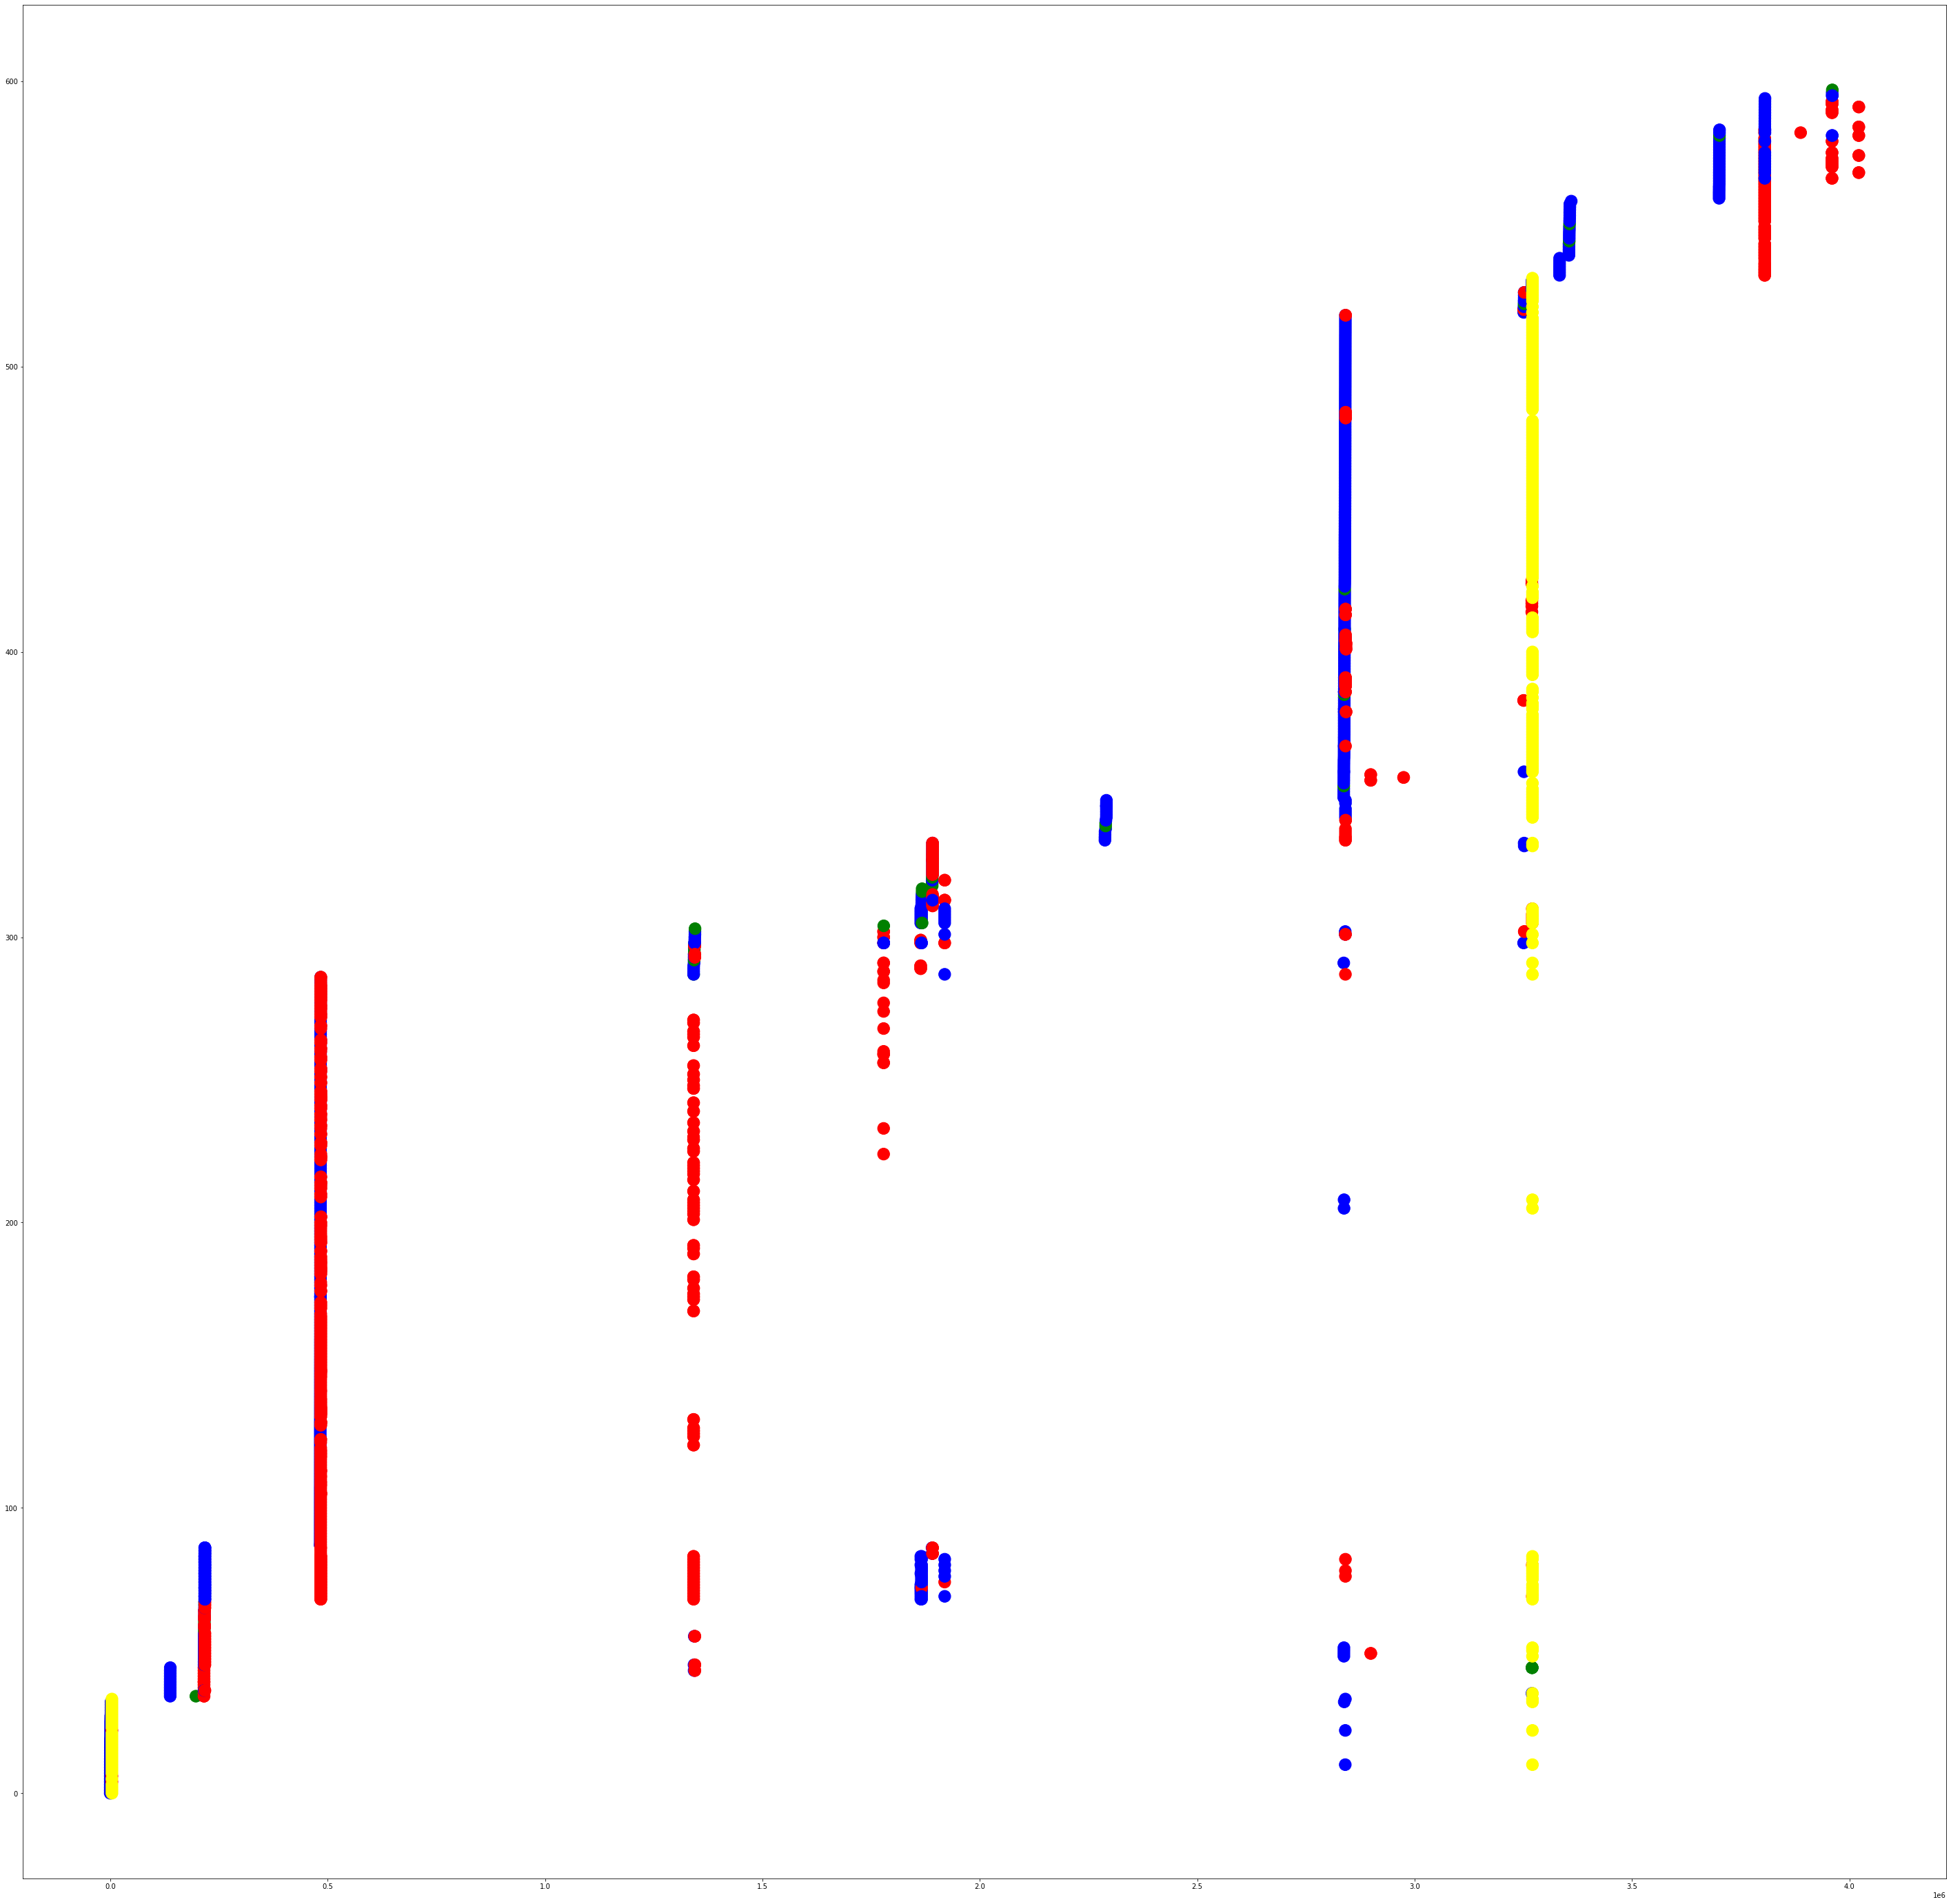

In [17]:
plot_df(user_data1)

# (2) Selfmade Detailed RFM
- R : Recency
- VF : View Frequency
- CF : Cart Frequency
- PF : Purchase Frequency
- M : Monetary
- P : purchase to purchase -> 구매 주기 평균
- C : first view to cart -> 평균
- V : first view to purchase -> 평균

In [6]:
def vcpr(df):
    cnt = 0
    pivot = 0
    view_date = []
    df['event_time'] = pd.to_datetime(df['event_time'])
    temp = pd.DataFrame(['2019-11-01 00:00:00 UTC'],columns=['event_time'])
    temp['event_time'] = pd.to_datetime(temp['event_time'])
    result = pd.DataFrame(columns=['user_id','category_id','vtop','ctop','purchase_time','view_cnt','cart_cnt','remove_from_cart_cnt'])
    
    for i in df.index:  
        if (df.loc[i,'event_type'] == 'purchase'):
            val = df.loc[i]
            view_list = df[(df['event_type']=='view') & \
                           (df['user_id'] ==val['user_id']) & \
                           (df['category_id']==val['category_id'])& \
                           (temp['event_time'].iloc[0] <= df['event_time'])& \
                           (df['event_time'] <= val['event_time'])]
            cart_list = df[(df['event_type']=='cart') & \
                           (df['user_id'] ==val['user_id']) & \
                           (df['category_id']==val['category_id'])& \
                           (temp['event_time'].iloc[0] <= df['event_time'])& \
                           (df['event_time'] <= val['event_time'])]
            rmcart_list = df[(df['event_type']=='remove_from_cart') & \
                           (df['user_id'] ==val['user_id']) & \
                           (df['category_id']==val['category_id'])& \
                           (temp['event_time'].iloc[0] <= df['event_time'])& \
                           (df['event_time'] <= val['event_time'])]
            ##print(view_list)
            ##print(cart_list)
            
            vtop = val['event_time'] - view_list['event_time'].min()
            ctop = val['event_time'] - cart_list['event_time'].min()
            
            view_cnt = len(view_list)
            cart_cnt = len(cart_list)
            rmcart_cnt = len(rmcart_list)
            ##print(view_cnt)
            ##print(cart_cnt)
            temp['event_time'] = val['event_time']
            result = result.append(pd.DataFrame([[val['user_id'],val['category_id'],vtop,ctop,val['event_time'],view_cnt,cart_cnt,rmcart_cnt]],
                                               columns=['user_id','category_id','vtop','ctop','purchase_time','view_cnt','cart_cnt','remove_from_cart_cnt']))
            continue
    
    return result

### 임의의 유저 데이터 Get

In [18]:
vcpr_data = temp[temp['user_id']==275131685]

In [19]:
vcpr_data[vcpr_data['event_type']=='purchase']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
10030,2019-11-01 05:51:28 UTC,purchase,5827009,2193074740552270669,NaN,NaN,4.38,275131685,f46489ce-90cb-424c-8f39-3f79c259826c
10031,2019-11-01 05:51:28 UTC,purchase,5894905,1487580010100293687,NaN,jessnail,1.10,275131685,f46489ce-90cb-424c-8f39-3f79c259826c
10032,2019-11-01 05:51:28 UTC,purchase,5887061,1487580010100293687,NaN,jessnail,1.10,275131685,f46489ce-90cb-424c-8f39-3f79c259826c
10033,2019-11-01 05:51:28 UTC,purchase,5887054,1487580010100293687,NaN,jessnail,1.10,275131685,f46489ce-90cb-424c-8f39-3f79c259826c
10034,2019-11-01 05:51:28 UTC,purchase,5882393,1783999068909863670,NaN,zinger,6.19,275131685,f46489ce-90cb-424c-8f39-3f79c259826c
...,...,...,...,...,...,...,...,...,...
2531947,2020-02-18 07:14:30 UTC,purchase,5820769,1487580006317032337,NaN,NaN,15.87,275131685,4660e348-0767-4ed9-9c12-0fba3ba64644
2531948,2020-02-18 07:14:30 UTC,purchase,5833659,1921723491720102387,NaN,NaN,5.71,275131685,4660e348-0767-4ed9-9c12-0fba3ba64644
2531949,2020-02-18 07:14:30 UTC,purchase,5833659,1921723491720102387,NaN,NaN,5.71,275131685,4660e348-0767-4ed9-9c12-0fba3ba64644
2531950,2020-02-18 07:14:30 UTC,purchase,5875296,1487580005092295511,NaN,NaN,7.22,275131685,4660e348-0767-4ed9-9c12-0fba3ba64644


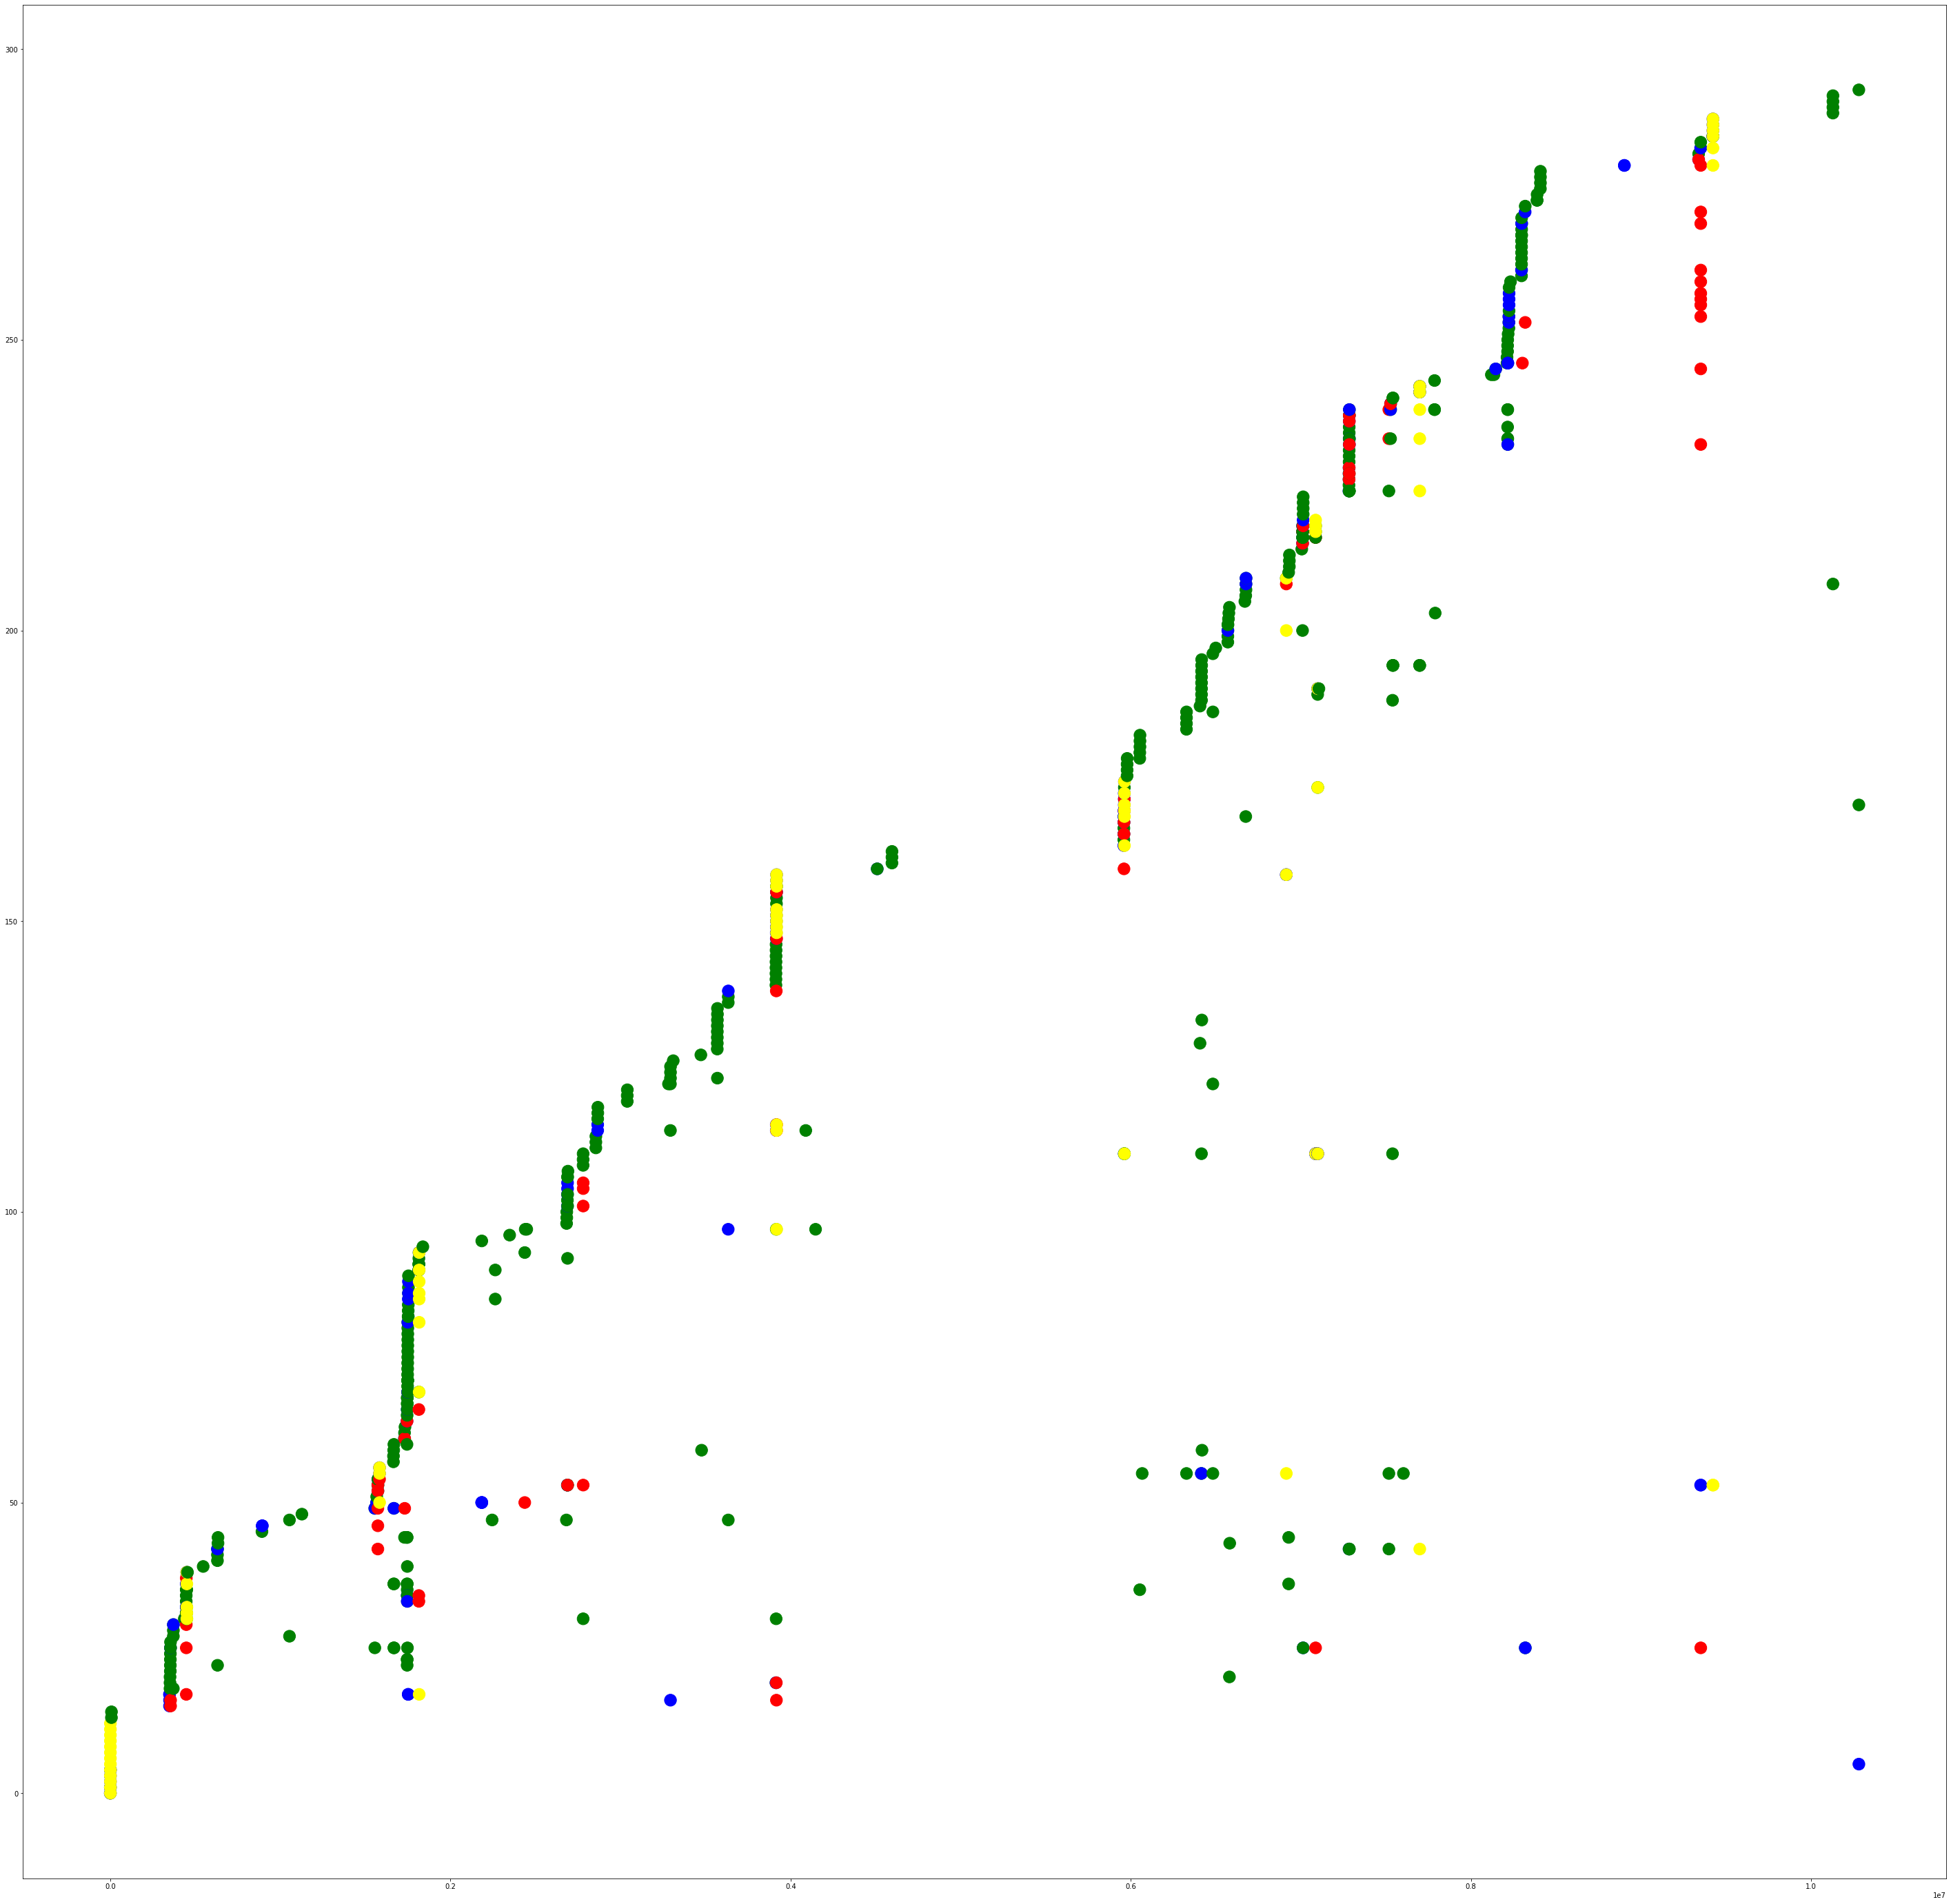

In [21]:
plot_df(vcpr_data)

In [22]:
vcpr(vcpr_data)

,user_id,category_id,vtop,ctop,purchase_time,view_cnt,cart_cnt,remove_from_cart_cnt
0,275131685,2193074740552270669,NaN,NaN,2019-11-01 05:51:28+00:00,0,0,0
0,275131685,1487580010100293687,NaN,NaN,2019-11-01 05:51:28+00:00,0,0,0
0,275131685,1487580010100293687,NaN,NaN,2019-11-01 05:51:28+00:00,0,0,0
0,275131685,1487580010100293687,NaN,NaN,2019-11-01 05:51:28+00:00,0,0,0
0,275131685,1783999068909863670,NaN,NaN,2019-11-01 05:51:28+00:00,0,0,0
...,...,...,...,...,...,...,...,...
0,275131685,1487580006317032337,NaN,NaN,2020-02-18 07:14:30+00:00,0,0,0
0,275131685,1921723491720102387,NaN,NaN,2020-02-18 07:14:30+00:00,0,0,0
0,275131685,1921723491720102387,NaN,NaN,2020-02-18 07:14:30+00:00,0,0,0
0,275131685,1487580005092295511,NaN,NaN,2020-02-18 07:14:30+00:00,0,0,0


In [23]:
vcp1 = vcpr(vcpr_data)

In [24]:
vcp1[vcp1['view_cnt']!=0]

,user_id,category_id,vtop,ctop,purchase_time,view_cnt,cart_cnt,remove_from_cart_cnt
0,275131685,1783999063314661546,0 days 00:59:06,0 days 00:58:02,2019-11-06 10:39:12+00:00,7,3,0
0,275131685,1487580005092295511,0 days 02:46:38,0 days 02:48:52,2019-11-19 13:27:16+00:00,1,3,1
0,275131685,2069804417665728971,0 days 18:59:09,0 days 18:58:37,2019-11-22 06:07:59+00:00,3,1,0
0,275131685,1487580010821714008,0 days 00:08:34,0 days 00:07:11,2019-12-16 13:54:26+00:00,3,3,1
0,275131685,1487580008145748965,0 days 00:56:47,0 days 00:53:41,2020-01-09 05:58:46+00:00,5,3,2
0,275131685,1487580005092295511,9 days 19:21:20,5 days 18:43:16,2020-01-20 06:23:05+00:00,14,2,0
0,275131685,1487580005671109489,0 days 21:14:24,0 days 21:17:30,2020-01-22 06:14:14+00:00,10,8,3
0,275131685,1487580005671109489,0 days 00:09:24,0 days 00:08:03,2020-01-22 09:46:40+00:00,3,4,0
0,275131685,1487580010100293687,0 days 00:09:07,0 days 00:06:08,2020-01-29 08:21:18+00:00,2,2,0
0,275131685,1487580006317032337,18 days 21:42:57,13 days 23:08:33,2020-02-18 07:14:30+00:00,7,10,6


In [25]:
vcpr_data2 = temp[temp['user_id']==10280338]

In [26]:
vcpr_data2[vcpr_data2['event_type']=='purchase']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2687147,2019-11-20 18:36:14 UTC,purchase,5809910,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2
2687149,2019-11-20 18:36:14 UTC,purchase,5809911,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2
2687151,2019-11-20 18:36:14 UTC,purchase,5809912,1602943681873052386,NaN,grattol,5.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2
2687152,2019-11-20 18:36:14 UTC,purchase,5862544,1487580006434472855,NaN,jas,0.24,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2
2687153,2019-11-20 18:36:14 UTC,purchase,5870648,1487580006451250072,NaN,airnails,1.59,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2
...,...,...,...,...,...,...,...,...,...
2749916,2020-02-19 15:21:31 UTC,purchase,5908265,1487580007675986893,NaN,NaN,1.43,10280338,9728269f-2014-4d85-a95a-0dab99c4851e
2749917,2020-02-19 15:21:31 UTC,purchase,5923723,1487580007675986893,NaN,NaN,1.43,10280338,9728269f-2014-4d85-a95a-0dab99c4851e
2749918,2020-02-19 15:21:31 UTC,purchase,5929016,1487580007675986893,NaN,NaN,1.43,10280338,9728269f-2014-4d85-a95a-0dab99c4851e
2749919,2020-02-19 15:21:31 UTC,purchase,5929036,1487580007675986893,NaN,NaN,1.43,10280338,9728269f-2014-4d85-a95a-0dab99c4851e


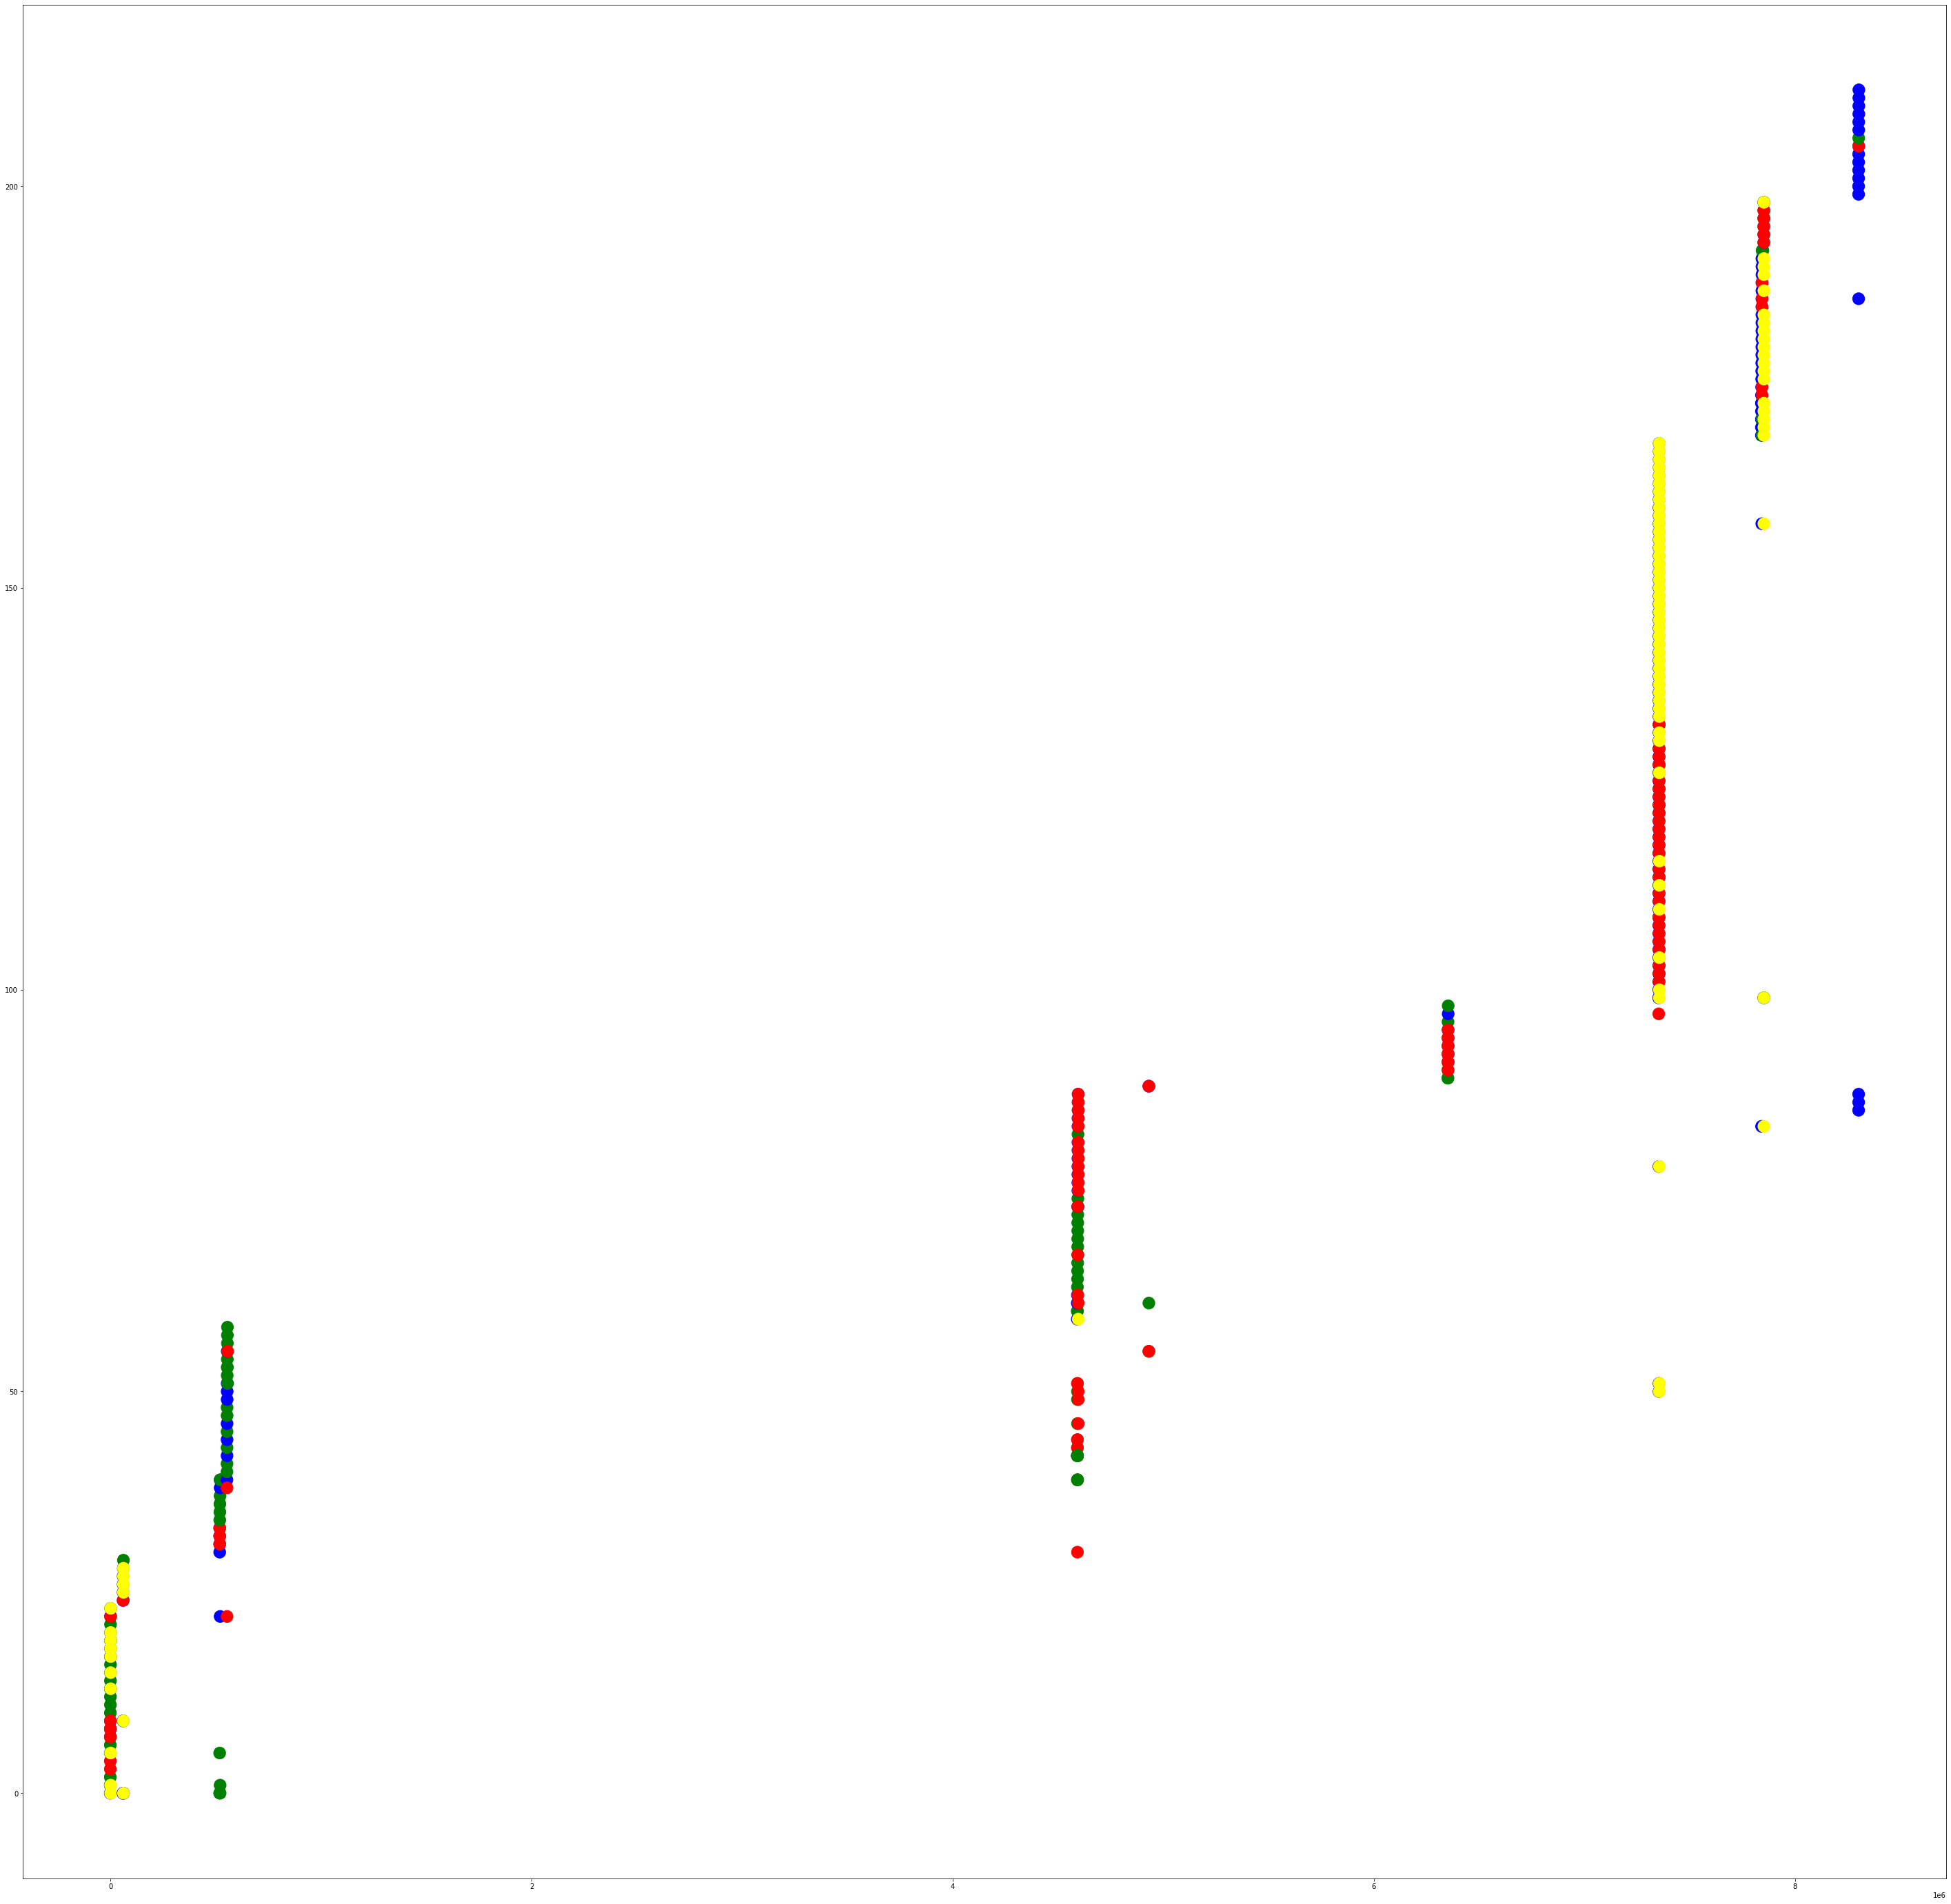

In [27]:
plot_df(vcpr_data2)

In [28]:
vcp2 = vcpr(vcpr_data2)

In [29]:
vcp2[vcp2['view_cnt']!=0]

,user_id,category_id,vtop,ctop,purchase_time,view_cnt,cart_cnt,remove_from_cart_cnt
0,10280338,1602943681873052386,0 days 00:26:44,0 days 00:28:00,2019-11-20 18:36:14+00:00,6,4,1
0,10280338,1602943681873052386,0 days 00:21:35,0 days 00:30:45,2019-11-21 11:31:09+00:00,1,10,1
0,10280338,1487580007717929935,0 days 00:03:46,0 days 00:09:01,2020-02-19 15:21:31+00:00,3,7,5


# (3) Analysis
- 생각보다 view -> cart -> purchase 순서로 정제된 구매 패턴이 많지 않음.
- category_id 만을 알 수 있을 뿐, 정확한 상품 카테고리를 알지 못해 vtop, ctop에서 인사이트를 뽑아내기 어려움.
- vcpr 함수가 Purchase 숫자는 제대로 뽑아내지만, view, cart를 모두 뽑아내고 있는지 여부가 의심됨.